<a href="https://colab.research.google.com/github/alfazick/AppliedLLMCourse/blob/main/Module1InferenceControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [13]:
import torch.nn.functional as F


prompt = "Transformer architecture is "
inputs = tokenizer(prompt,return_tensors = "pt")

with torch.no_grad():
    out = model(**inputs)
    raw_logits = out.logits

last_row = raw_logits[:,-1,:]

# Let us start to formalize different techniques

# Greedy

def greedy_decode(raw_logits):
    probs = F.softmax(raw_logits,dim=-1)
    next_token = torch.argmax(probs,dim=-1)
    return next_token


nxt_token_id = greedy_decode(last_row).item()

print(nxt_token_id)
print(tokenizer.decode([nxt_token_id]))

# ok that's not that useful, but good for recalling the procedure

16
1


In [14]:

# ok so we already familiar with this function
def generate(model,tokenizer,prompt,max_length=10,fn_decode_strategy=greedy_decode):
    inputs = tokenizer(prompt,return_tensors="pt")

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    generated_tokens = list()

    for step in range(max_length):
        with torch.no_grad():
            out = model(input_ids = input_ids,
                        attention_mask = attention_mask)

            logits_last = out.logits[:,-1,:]


            ### Core plugin idea of decode_strategy

            next_token_id = fn_decode_strategy(logits_last)

            token_id_int = next_token_id.item()

            # next token text
            next_token = tokenizer.decode(token_id_int)

            if tokenizer.eos_token_id is not None and token_id_int == tokenizer.eos_token_id:
                break

            generated_tokens.append(next_token)

            # now let's update inputs, since we want to continue generations
            # with newly minted token in context

            # append to context: make shape [1,1], then cat
            next_token_2d = next_token_id.view(1, 1)        # [1, 1]

            input_ids = torch.cat([input_ids, next_token_2d], dim=1)

            attention_mask = torch.cat(
                [attention_mask, torch.ones((1, 1), dtype=attention_mask.dtype)], dim=1
            )

    continuation = "".join(generated_tokens)

    return continuation, prompt + continuation



In [20]:
# let's test greedy

_,res = generate(model,tokenizer,prompt,10,greedy_decode)
print(res)

Transformer architecture is 100% open source, and is available


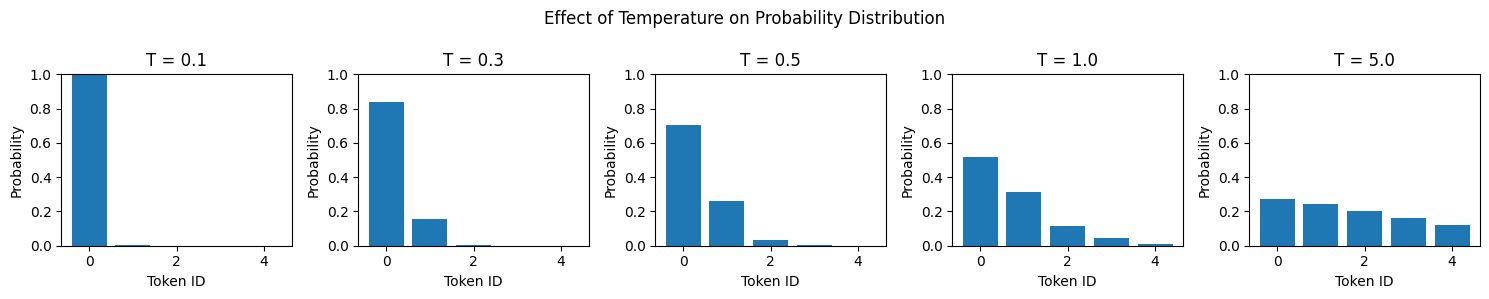

In [29]:
# so next idea is "what is a temperature?"
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_temperature_effects():
    # Example logits for 5 tokens
    logits = torch.tensor([2.0, 1.5, 0.5, -0.5, -2.0])
    temperatures = [0.1, 0.3, 0.5, 1.0,5.0]

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for idx, temp in enumerate(temperatures):
        changed_logits = logits/temp
        # so please notice  temperature is applied in way by division
        # so basically if value was big it becomes bigger when temp in
        # range(0,1)
        # and obviosuly you can see after 1, it flattens most of the values
        # so like it almost became random


        probs = F.softmax(changed_logits,dim=-1)

        axes[idx].bar(range(len(probs)), probs.numpy())
        axes[idx].set_title(f'T = {temp}')
        axes[idx].set_ylim(0, 1)
        axes[idx].set_xlabel('Token ID')
        axes[idx].set_ylabel('Probability')

    plt.suptitle('Effect of Temperature on Probability Distribution')
    plt.tight_layout()
    plt.show()

visualize_temperature_effects()

# so this one should be pretty mach illustrative

In [30]:
def demonstrate_division_effect():
    """
    Show how division by temperature amplifies or dampens differences
    """
    original_logit = 6.0

    print("Original logit: 6.0")
    print("=" * 50)

    print("\nTEMPERATURE < 1 (Division by fraction = MULTIPLICATION)")
    for temp in [0.1, 0.3, 0.5, 0.7, 0.9]:
        scaled = original_logit / temp
        print(f"6.0 / {temp} = {scaled:.1f} (multiplied by {1/temp:.1f})")

    print("\nTEMPERATURE > 1 (Division = SHRINKING)")
    for temp in [1.0, 1.5, 2.0, 3.0, 5.0]:
        scaled = original_logit / temp
        print(f"6.0 / {temp} = {scaled:.1f} (divided by {temp})")

demonstrate_division_effect()

Original logit: 6.0

TEMPERATURE < 1 (Division by fraction = MULTIPLICATION)
6.0 / 0.1 = 60.0 (multiplied by 10.0)
6.0 / 0.3 = 20.0 (multiplied by 3.3)
6.0 / 0.5 = 12.0 (multiplied by 2.0)
6.0 / 0.7 = 8.6 (multiplied by 1.4)
6.0 / 0.9 = 6.7 (multiplied by 1.1)

TEMPERATURE > 1 (Division = SHRINKING)
6.0 / 1.0 = 6.0 (divided by 1.0)
6.0 / 1.5 = 4.0 (divided by 1.5)
6.0 / 2.0 = 3.0 (divided by 2.0)
6.0 / 3.0 = 2.0 (divided by 3.0)
6.0 / 5.0 = 1.2 (divided by 5.0)


In [31]:
#Assignment : Implement text_generation, apply greedy with different temperatures

# there are like dozen different techniques, to explore
# but we finish with another two

In [35]:
# top-k sampling

# algo find_k_largest values,filter only those values, softmax to get probs
# out of those probs get random one, according to given probabilities

def simple_top_k(raw_logits,k = 5):
    # step 1 find k_largest values, we also need their indices, since it's effectivly token_ids
    top_k_logits,top_k_indices = torch.topk(raw_logits,k)

    # step 2 create new_logits and filter
    filtered_logits = torch.full_like(raw_logits, float('-inf'))
    # Use scatter to put values back
    filtered_logits.scatter_(-1, top_k_indices, top_k_logits)

    # step 3 sample one according to probs
    probs = F.softmax(filtered_logits,dim=-1)
    next_token = torch.multinomial(probs, 1)

    return next_token

_,res = generate(model,tokenizer,prompt,15,simple_top_k)
print(res)

Transformer architecture is 100% open-source and open to anyone to contribute.
The Transformer


In [48]:
# top-p(nucleus) sampling

# algo:
# 1) apply softmax to get probabilities and sort them
# 2)keep tokens by adding their probabilities till reaching thershold
# 3) sample random token haha, I don't know why but
# everything is a random, but it works almost

def simple_top_p(raw_logits,p = 0.7):
    # step1 get probs and sort them
    probs = F.softmax(raw_logits,dim=-1)
    sorted_probs,sorted_indices = torch.sort(probs,descending =True) # so highes probs goes first

    # step2 cumulative_sum
    cumsum_probs = torch.cumsum(sorted_probs,dim=-1)

    tokens_to_remove = cumsum_probs > p # this will mask all tokens to remove = True
    tokens_to_remove[..., 0] = False  # Keep at least first token # try to comment to see the problem
    # "No matter how aggressive our filtering is, always keep the best token!"

    # Create filtered logits
    filtered_logits = raw_logits.clone()

    # Use scatter to map removal mask back to original positions
    indices_to_remove = tokens_to_remove.scatter(-1, sorted_indices, tokens_to_remove)
    filtered_logits[indices_to_remove] = float('-inf')

    # Sample
    probs = F.softmax(filtered_logits, dim=-1)
    next_token = torch.multinomial(probs, 1)

    return next_token


_,res = generate(model,tokenizer,prompt,15,simple_top_p)
print(res)

Transformer architecture is 1) designed to provide the best results in the context of specific performance requirements


In [38]:

# sorting
import torch

# Simple example
values = torch.tensor([3.0, 1.0, 4.0, 1.5, 2.0])
print("Original:", values)

# Sort in ascending order (default)
sorted_vals, sorted_idx = torch.sort(values)
print("\nAscending:")
print("Sorted values:", sorted_vals)  # [1.0, 1.5, 2.0, 3.0, 4.0]
print("Sorted indices:", sorted_idx)  # [1, 3, 4, 0, 2]
#                                        ↑ means values[1]=1.0 is smallest

# Sort in descending order
sorted_vals, sorted_idx = torch.sort(values, descending=True)
print("\nDescending:")
print("Sorted values:", sorted_vals)  # [4.0, 3.0, 2.0, 1.5, 1.0]
print("Sorted indices:", sorted_idx)  # [2, 0, 4, 3, 1]
#                                        ↑ means values[2]=4.0 is largest

# What do indices mean?
print("\nReconstruct original from sorted:")
print("values[sorted_idx] =", values[sorted_idx])
print("This equals sorted_vals:", sorted_vals)

Original: tensor([3.0000, 1.0000, 4.0000, 1.5000, 2.0000])

Ascending:
Sorted values: tensor([1.0000, 1.5000, 2.0000, 3.0000, 4.0000])
Sorted indices: tensor([1, 3, 4, 0, 2])

Descending:
Sorted values: tensor([4.0000, 3.0000, 2.0000, 1.5000, 1.0000])
Sorted indices: tensor([2, 0, 4, 3, 1])

Reconstruct original from sorted:
values[sorted_idx] = tensor([4.0000, 3.0000, 2.0000, 1.5000, 1.0000])
This equals sorted_vals: tensor([4.0000, 3.0000, 2.0000, 1.5000, 1.0000])


In [39]:
# cumsum
# Cumulative sum - running total
probs = torch.tensor([0.4, 0.3, 0.15, 0.1, 0.05])
print("Original probs:", probs)

cumsum = torch.cumsum(probs, dim=-1)
print("Cumulative sum:", cumsum)
# [0.4, 0.7, 0.85, 0.95, 1.0]
#   ↑    ↑     ↑     ↑    ↑
#  0.4  +0.3  +0.15 +0.1 +0.05

# Visual breakdown:
print("\nStep by step:")
print(f"Position 0: {probs[0]:.2f} = {probs[0]:.2f}")
print(f"Position 1: {probs[0]:.2f} + {probs[1]:.2f} = {cumsum[1]:.2f}")
print(f"Position 2: {probs[0]:.2f} + {probs[1]:.2f} + {probs[2]:.2f} = {cumsum[2]:.2f}")

# Why useful for top-p?
p = 0.9
print(f"\nFor p={p}, we want tokens until cumsum > {p}")
print("Mask:", cumsum > p)  # [False, False, False, True, True]
print("So we keep first 3 tokens (cumsum = 0.85)")

Original probs: tensor([0.4000, 0.3000, 0.1500, 0.1000, 0.0500])
Cumulative sum: tensor([0.4000, 0.7000, 0.8500, 0.9500, 1.0000])

Step by step:
Position 0: 0.40 = 0.40
Position 1: 0.40 + 0.30 = 0.70
Position 2: 0.40 + 0.30 + 0.15 = 0.85

For p=0.9, we want tokens until cumsum > 0.9
Mask: tensor([False, False, False,  True,  True])
So we keep first 3 tokens (cumsum = 0.85)


In [41]:
# tricky one is scatter
# Scatter: puts values at specified positions
# Think of it as "reverse indexing"

# Example 1: Basic scatter
target = torch.zeros(5)
indices = torch.tensor([2, 0, 4])  # Where to put values
values = torch.tensor([10., 20., 30.])  # What to put

target.scatter_(0, indices, values)
print("After scatter:", target)  # [20., 0., 10., 0., 30.]
#                                     ↑        ↑         ↑
#                                  idx=0     idx=2     idx=4



After scatter: tensor([20.,  0., 10.,  0., 30.])


In [48]:
# ok based on these 3 ideas, it seems like they can kill each other
# so for example if temp is low, it automatically makes one probability higher so basicaly top_p is useless,
# since I will sample from 1

In [49]:
# so less is more
def the_bottom_line():

    print("The Paradox:")
    print("-" * 40)
    print("Low temp → Peaked distribution → Top-p keeps 1 token")
    print("High temp → Flat distribution → Top-k becomes limiting factor")

    print("\nThe Solution:")
    print("-" * 40)
    print("DON'T use all three at full strength!")
    print("")
    print("Option 1: temp(0.7-0.9) + top_p(0.9)")
    print("Option 2: temp(0.3-0.5) + top_k(20)")
    print("Option 3: temp(0.0) + nothing (greedy)") # here notice the bug I have in my code
    # let's address it !

    print("\nThe Rule of Thumb:")
    print("-" * 40)
    print("If temp < 0.5: Don't bother with top-p")
    print("If temp > 1.5: You need constraints (top-k or top-p)")
    print("If temp ≈ 1.0: Both top-k and top-p are useful")

the_bottom_line()

The Paradox:
----------------------------------------
Low temp → Peaked distribution → Top-p keeps 1 token
High temp → Flat distribution → Top-k becomes limiting factor

The Solution:
----------------------------------------
DON'T use all three at full strength!

Option 1: temp(0.7-0.9) + top_p(0.9)
Option 2: temp(0.3-0.5) + top_k(20)
Option 3: temp(0.0) + nothing (greedy)

The Rule of Thumb:
----------------------------------------
If temp < 0.5: Don't bother with top-p
If temp > 1.5: You need constraints (top-k or top-p)
If temp ≈ 1.0: Both top-k and top-p are useful
